# Tugas01-ML-H071191049 (Association Rule Mining Menggunakan Algoritma Apriori)

Mengimport Library yang akan digunakan

In [1]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
%matplotlib inline

## Contoh 1, Dataset Online Retail

Data yang di gunakan merupakan data transaksi dari sebuah pusat grosir yang melayani transaksi di beberapa negara.


Data Source : https://www.kaggle.com/mashlyn/online-retail-ii-uci

### 1. Meload dan Mengeksplor dataset


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
file = 'drive/My Drive/Dataset/online_retail_II.xlsx'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Memuat Data Menggunakan library Pandas

In [3]:
df = pd.read_excel(file)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Datanya terdiri dari 8 Variabel
1. Invoice : Nomor nota pada setiap pembelian
2. StockCode : Merupakan kode stok dari sebuah barang
3. Description : Deskripsi dari barang tersebut.
4. Quantitiy : Jumlah barang yang di beli pada sebuah transaksi.
5. InvoiceDate : tanggal pembelian
6. Unit Price : Harga per unit barang
7. CustomerID : ID Dari pelanggan
8. Country : Negara dari pelangan.

### 2. Menghapus semua nilai Null

Menghilangkan Spasi sebelum dan setelah variabel Description

In [4]:
df["Description"] = df["Description"].str.strip()

Menghapus variabel *invoice* yang kosong

In [5]:
# Mengecek jumlah data yang null dan non-null pada tiap kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522530 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
# axis=0 berarti drop semua baris yang kosong
# subset["Invoice"] berarti drop yang kolom invoicenya kosong
# inplace=True berari method ini tidak akan mengembalikan apa-apa (None)
df.dropna(axis=0, subset=['Invoice'], inplace=True)

### 3. Menggunakan data yang nilai kolom "Quantity" positif

In [7]:
df["Quantity"].describe()

count    525461.000000
mean         10.337667
std         107.424110
min       -9600.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       19152.000000
Name: Quantity, dtype: float64

Karena data quantity mengandung nilai negatif oleh karena itu difilter untuk dengan mengambil yang hanya lebih besar 0

In [8]:
df = df[df["Quantity"]>=0]
df["Quantity"].describe()

count    513135.000000
mean         11.715412
std          92.974635
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       19152.000000
Name: Quantity, dtype: float64

### 4. Memisahkan data sesuai dengan wilayah transaksi

In [9]:
# Mengecek berapa negara berbeda yang terdapat pada database
df["Country"].unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Denmark', 'Netherlands', 'Poland',
       'Channel Islands', 'Spain', 'Cyprus', 'Greece', 'Norway',
       'Austria', 'Sweden', 'United Arab Emirates', 'Finland', 'Italy',
       'Switzerland', 'Japan', 'Unspecified', 'Nigeria', 'Malta',
       'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore', 'Thailand',
       'Israel', 'Lithuania', 'West Indies', 'Lebanon', 'Korea', 'Brazil',
       'Canada', 'Iceland'], dtype=object)

Setelah data dibersihkan selanjutnya adalah membuat keranjang belanja yang dikenali berdasarkan nomor invoice,

Misalnya kita akan membatasi data dengan hanya menggunakan transaksi pada negara **Japan**

In [10]:
# Mengatur agar hanya menggunakan transaksi satu negara saja
df_country = (df[df["Country"] == "Sweden"])
df_country.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
20893,491059,21731,RED TOADSTOOL LED NIGHT LIGHT,144,2009-12-09 11:36:00,1.45,12487.0,Sweden
20894,491059,21252,SET OF MEADOW FLOWER STICKERS,30,2009-12-09 11:36:00,2.55,12487.0,Sweden
47215,493806,POST,POSTAGE,1,2010-01-07 11:31:00,18.00,17404.0,Sweden
47216,493806,22348,TEA BAG PLATE RED SPOTTY,1,2010-01-07 11:31:00,0.85,17404.0,Sweden
47217,493806,22357,KINGS CHOICE BISCUIT TIN,1,2010-01-07 11:31:00,4.25,17404.0,Sweden


In [11]:
# Membuat dataframe baru dengan Invoice sebagai index, Description sebagai Column, dan Valuenya berdasarkan Quantity
df_basket = df_country.pivot_table(index='Invoice',columns='Description', values='Quantity', aggfunc='sum')

# Dapat juga menggunakan
# df_basket = df_japan.groupby(["Invoice", "Description"])["Quantity"].sum().unstack()
df_basket

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE RED SPOTTY,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,20 DOLLY PEGS RETROSPOT,36 DOILIES DOLLY GIRL,36 DOILIES SPACEBOY DESIGN,36 DOILIES VINTAGE CHRISTMAS,36 PENCILS TUBE RED RETROSPOT,4 TRADITIONAL SPINNING TOPS,6 RIBBONS RUSTIC CHARM,6 ROCKET BALLOONS,60 CAKE CASES DOLLY GIRL DESIGN,60 CAKE CASES VINTAGE CHRISTMAS,60 TEATIME FAIRY CAKE CASES,72 SWEETHEART FAIRY CAKE CASES,75 GREEN FAIRY CAKE CASES,"ACRYLIC JEWEL ICICLE, BLUE",ADVENT CALENDAR GINGHAM SACK,AIRLINE BAG VINTAGE JET SET RED,AIRLINE BAG VINTAGE WORLD CHAMPION,ASSORTED CAKES FRIDGE MAGNETS,ASSORTED COLOURS SILK FAN,ASSORTED ICE CREAM FRIDGE MAGNETS,ASSORTED TUTTI FRUTTI LARGE PURSE,ASSORTED TUTTI FRUTTI NOTEBOOK,ASSORTED TUTTI FRUTTI ROUND BOX,ASSTD DESIGN BUBBLE GUM RING,BABUSHKA LIGHTS STRING OF 10,BAG 250g SWIRLY MARBLES,BAKING SET 9 PIECE RETROSPOT,BAKING SET SPACEBOY DESIGN,BALLOON PUMP WITH 10 BALLOONS,...,TV DINNER TRAY AIR HOSTESS,VINTAGE HEADS AND TAILS CARD GAME,VINTAGE KITCHEN PRINT PUDDINGS,VINTAGE RED TEATIME MUG,VINTAGE SNAKES & LADDERS,WALL TIDY RETROSPOT,WASH BAG VINTAGE ROSE PAISLEY,WATERING CAN BLUE ELEPHANT,WATERING CAN GARDEN MARKER,WATERING CAN GREEN DINOSAUR,WATERING CAN PINK BUNNY,WEEKEND BAG VINTAGE ROSE PAISLEY,WELCOME WOODEN BLOCK LETTERS,WHITE HANGING HEART T-LIGHT HOLDER,WOOD BLACK BOARD ANT WHITE FINISH,WOOD STOCKING CHRISTMAS SCANDISPOT,WOODEN ADVENT CALENDAR CREAM,WOODEN ADVENT CALENDAR RED,WOODEN BOX ADVENT CALENDAR,WOODEN BOX OF DOMINOES,WOODEN CROQUET GARDEN SET,WOODEN HAPPY BIRTHDAY GARLAND,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN OWLS LIGHT GARLAND,WOODEN REGATTA BUNTING,WOODEN SCHOOL COLOURING SET,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN TREE CHRISTMAS SCANDINAVIAN,WOODEN UNION JACK BUNTING,WOODLAND HEIGHT CHART STICKERS,WOODLAND ANIMAL WRITING SET,WOODLAND CHARLOTTE BAG,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND PARTY BAG + STICKER SET,WOODLAND WATER TRANSFER TATTOOS,WOOLLY HAT SOCK GLOVE ADVENT STRING,WORLD WAR 2 GLIDERS ASSTD DESIGNS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC WILLIE WINKIE CANDLE STICK
Invoice,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
491059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
494919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240.0,240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [12]:
df_basket.shape

(69, 449)

In [13]:
# Membatasi Jumlah Baris jika demensi terlalu besar 
df_basket_limit = df_basket.reset_index()
df_basket_limit = df_basket_limit.iloc[0:51, :].set_index("Invoice")
df_basket_limit.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE RED SPOTTY,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,20 DOLLY PEGS RETROSPOT,36 DOILIES DOLLY GIRL,36 DOILIES SPACEBOY DESIGN,36 DOILIES VINTAGE CHRISTMAS,36 PENCILS TUBE RED RETROSPOT,4 TRADITIONAL SPINNING TOPS,6 RIBBONS RUSTIC CHARM,6 ROCKET BALLOONS,60 CAKE CASES DOLLY GIRL DESIGN,60 CAKE CASES VINTAGE CHRISTMAS,60 TEATIME FAIRY CAKE CASES,72 SWEETHEART FAIRY CAKE CASES,75 GREEN FAIRY CAKE CASES,"ACRYLIC JEWEL ICICLE, BLUE",ADVENT CALENDAR GINGHAM SACK,AIRLINE BAG VINTAGE JET SET RED,AIRLINE BAG VINTAGE WORLD CHAMPION,ASSORTED CAKES FRIDGE MAGNETS,ASSORTED COLOURS SILK FAN,ASSORTED ICE CREAM FRIDGE MAGNETS,ASSORTED TUTTI FRUTTI LARGE PURSE,ASSORTED TUTTI FRUTTI NOTEBOOK,ASSORTED TUTTI FRUTTI ROUND BOX,ASSTD DESIGN BUBBLE GUM RING,BABUSHKA LIGHTS STRING OF 10,BAG 250g SWIRLY MARBLES,BAKING SET 9 PIECE RETROSPOT,BAKING SET SPACEBOY DESIGN,BALLOON PUMP WITH 10 BALLOONS,...,TV DINNER TRAY AIR HOSTESS,VINTAGE HEADS AND TAILS CARD GAME,VINTAGE KITCHEN PRINT PUDDINGS,VINTAGE RED TEATIME MUG,VINTAGE SNAKES & LADDERS,WALL TIDY RETROSPOT,WASH BAG VINTAGE ROSE PAISLEY,WATERING CAN BLUE ELEPHANT,WATERING CAN GARDEN MARKER,WATERING CAN GREEN DINOSAUR,WATERING CAN PINK BUNNY,WEEKEND BAG VINTAGE ROSE PAISLEY,WELCOME WOODEN BLOCK LETTERS,WHITE HANGING HEART T-LIGHT HOLDER,WOOD BLACK BOARD ANT WHITE FINISH,WOOD STOCKING CHRISTMAS SCANDISPOT,WOODEN ADVENT CALENDAR CREAM,WOODEN ADVENT CALENDAR RED,WOODEN BOX ADVENT CALENDAR,WOODEN BOX OF DOMINOES,WOODEN CROQUET GARDEN SET,WOODEN HAPPY BIRTHDAY GARLAND,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN OWLS LIGHT GARLAND,WOODEN REGATTA BUNTING,WOODEN SCHOOL COLOURING SET,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN TREE CHRISTMAS SCANDINAVIAN,WOODEN UNION JACK BUNTING,WOODLAND HEIGHT CHART STICKERS,WOODLAND ANIMAL WRITING SET,WOODLAND CHARLOTTE BAG,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND PARTY BAG + STICKER SET,WOODLAND WATER TRANSFER TATTOOS,WOOLLY HAT SOCK GLOVE ADVENT STRING,WORLD WAR 2 GLIDERS ASSTD DESIGNS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC WILLIE WINKIE CANDLE STICK
Invoice,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
491059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
494919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240.0,240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [14]:
# Mengubah NaN menjadi 0
df_basket_clean = df_basket_limit.fillna(0)
df_basket_clean.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE RED SPOTTY,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,20 DOLLY PEGS RETROSPOT,36 DOILIES DOLLY GIRL,36 DOILIES SPACEBOY DESIGN,36 DOILIES VINTAGE CHRISTMAS,36 PENCILS TUBE RED RETROSPOT,4 TRADITIONAL SPINNING TOPS,6 RIBBONS RUSTIC CHARM,6 ROCKET BALLOONS,60 CAKE CASES DOLLY GIRL DESIGN,60 CAKE CASES VINTAGE CHRISTMAS,60 TEATIME FAIRY CAKE CASES,72 SWEETHEART FAIRY CAKE CASES,75 GREEN FAIRY CAKE CASES,"ACRYLIC JEWEL ICICLE, BLUE",ADVENT CALENDAR GINGHAM SACK,AIRLINE BAG VINTAGE JET SET RED,AIRLINE BAG VINTAGE WORLD CHAMPION,ASSORTED CAKES FRIDGE MAGNETS,ASSORTED COLOURS SILK FAN,ASSORTED ICE CREAM FRIDGE MAGNETS,ASSORTED TUTTI FRUTTI LARGE PURSE,ASSORTED TUTTI FRUTTI NOTEBOOK,ASSORTED TUTTI FRUTTI ROUND BOX,ASSTD DESIGN BUBBLE GUM RING,BABUSHKA LIGHTS STRING OF 10,BAG 250g SWIRLY MARBLES,BAKING SET 9 PIECE RETROSPOT,BAKING SET SPACEBOY DESIGN,BALLOON PUMP WITH 10 BALLOONS,...,TV DINNER TRAY AIR HOSTESS,VINTAGE HEADS AND TAILS CARD GAME,VINTAGE KITCHEN PRINT PUDDINGS,VINTAGE RED TEATIME MUG,VINTAGE SNAKES & LADDERS,WALL TIDY RETROSPOT,WASH BAG VINTAGE ROSE PAISLEY,WATERING CAN BLUE ELEPHANT,WATERING CAN GARDEN MARKER,WATERING CAN GREEN DINOSAUR,WATERING CAN PINK BUNNY,WEEKEND BAG VINTAGE ROSE PAISLEY,WELCOME WOODEN BLOCK LETTERS,WHITE HANGING HEART T-LIGHT HOLDER,WOOD BLACK BOARD ANT WHITE FINISH,WOOD STOCKING CHRISTMAS SCANDISPOT,WOODEN ADVENT CALENDAR CREAM,WOODEN ADVENT CALENDAR RED,WOODEN BOX ADVENT CALENDAR,WOODEN BOX OF DOMINOES,WOODEN CROQUET GARDEN SET,WOODEN HAPPY BIRTHDAY GARLAND,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN OWLS LIGHT GARLAND,WOODEN REGATTA BUNTING,WOODEN SCHOOL COLOURING SET,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN TREE CHRISTMAS SCANDINAVIAN,WOODEN UNION JACK BUNTING,WOODLAND HEIGHT CHART STICKERS,WOODLAND ANIMAL WRITING SET,WOODLAND CHARLOTTE BAG,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND PARTY BAG + STICKER SET,WOODLAND WATER TRANSFER TATTOOS,WOOLLY HAT SOCK GLOVE ADVENT STRING,WORLD WAR 2 GLIDERS ASSTD DESIGNS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC WILLIE WINKIE CANDLE STICK
Invoice,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
491059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
493806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
494919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,240.0,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### 5. Encode Data

Kita ingin mengencode data basket menjadi data biner. Jadi didefinisikan suatu fungsi yang akan mengubah semua nilai diatas 0 (Terdapat transaksi) menjadi 1, dan yang sama dengan 0 (Tidak terdapat transaksi) tetap 0.

In [15]:
def encode_units(x):
  if x <= 0:
    return 0
  if x >= 1:
    return 1

Menerapkan encode data ke dataset basket

In [16]:
df_basket_encode = df_basket_clean.applymap(encode_units)
df_basket_encode.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE RED SPOTTY,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,20 DOLLY PEGS RETROSPOT,36 DOILIES DOLLY GIRL,36 DOILIES SPACEBOY DESIGN,36 DOILIES VINTAGE CHRISTMAS,36 PENCILS TUBE RED RETROSPOT,4 TRADITIONAL SPINNING TOPS,6 RIBBONS RUSTIC CHARM,6 ROCKET BALLOONS,60 CAKE CASES DOLLY GIRL DESIGN,60 CAKE CASES VINTAGE CHRISTMAS,60 TEATIME FAIRY CAKE CASES,72 SWEETHEART FAIRY CAKE CASES,75 GREEN FAIRY CAKE CASES,"ACRYLIC JEWEL ICICLE, BLUE",ADVENT CALENDAR GINGHAM SACK,AIRLINE BAG VINTAGE JET SET RED,AIRLINE BAG VINTAGE WORLD CHAMPION,ASSORTED CAKES FRIDGE MAGNETS,ASSORTED COLOURS SILK FAN,ASSORTED ICE CREAM FRIDGE MAGNETS,ASSORTED TUTTI FRUTTI LARGE PURSE,ASSORTED TUTTI FRUTTI NOTEBOOK,ASSORTED TUTTI FRUTTI ROUND BOX,ASSTD DESIGN BUBBLE GUM RING,BABUSHKA LIGHTS STRING OF 10,BAG 250g SWIRLY MARBLES,BAKING SET 9 PIECE RETROSPOT,BAKING SET SPACEBOY DESIGN,BALLOON PUMP WITH 10 BALLOONS,...,TV DINNER TRAY AIR HOSTESS,VINTAGE HEADS AND TAILS CARD GAME,VINTAGE KITCHEN PRINT PUDDINGS,VINTAGE RED TEATIME MUG,VINTAGE SNAKES & LADDERS,WALL TIDY RETROSPOT,WASH BAG VINTAGE ROSE PAISLEY,WATERING CAN BLUE ELEPHANT,WATERING CAN GARDEN MARKER,WATERING CAN GREEN DINOSAUR,WATERING CAN PINK BUNNY,WEEKEND BAG VINTAGE ROSE PAISLEY,WELCOME WOODEN BLOCK LETTERS,WHITE HANGING HEART T-LIGHT HOLDER,WOOD BLACK BOARD ANT WHITE FINISH,WOOD STOCKING CHRISTMAS SCANDISPOT,WOODEN ADVENT CALENDAR CREAM,WOODEN ADVENT CALENDAR RED,WOODEN BOX ADVENT CALENDAR,WOODEN BOX OF DOMINOES,WOODEN CROQUET GARDEN SET,WOODEN HAPPY BIRTHDAY GARLAND,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN OWLS LIGHT GARLAND,WOODEN REGATTA BUNTING,WOODEN SCHOOL COLOURING SET,WOODEN STAR CHRISTMAS SCANDINAVIAN,WOODEN TREE CHRISTMAS SCANDINAVIAN,WOODEN UNION JACK BUNTING,WOODLAND HEIGHT CHART STICKERS,WOODLAND ANIMAL WRITING SET,WOODLAND CHARLOTTE BAG,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND PARTY BAG + STICKER SET,WOODLAND WATER TRANSFER TATTOOS,WOOLLY HAT SOCK GLOVE ADVENT STRING,WORLD WAR 2 GLIDERS ASSTD DESIGNS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC WILLIE WINKIE CANDLE STICK
Invoice,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
491059,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
493806,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
494919,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
496326,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
497496,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 6. Memfilter Transaksi: Hanya untuk Pembelian yang Lebih dari 1 Item

Karena akan dilihat hubungan antara 2 atau lebih item. Jadi kurang bermanfaat jika transaksi hanya membeli satu item. Oleh karena itu, langkah selanjutnya adalah menyaring transaksi yang membeli lebih dari 1 item.

In [17]:
# Filter bekerja dengan melihat jumlah kolom yang nilainya 1 pada tiap baris
# dan Hanya akan mengambil yang nilanya lebih besar atau sama dengan 2 
df_basket_filter = df_basket_encode[(df_basket_encode > 0).sum(axis=1) >= 2]
df_basket_filter.shape

(46, 449)

Visualisasi Jumlah transaksi berdasarkan item yang paling banyak terjual

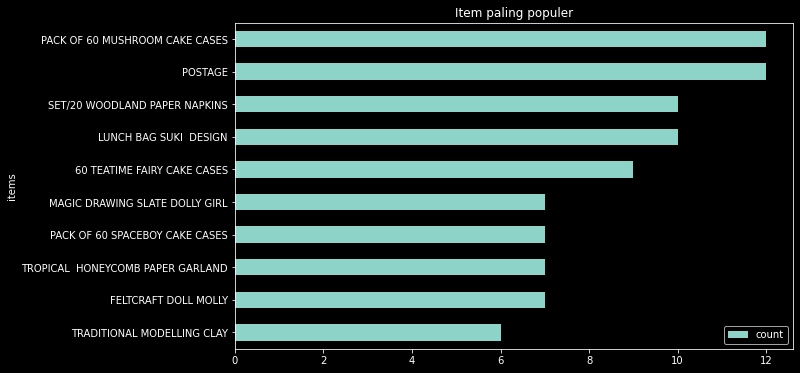

In [18]:
count = df_basket_filter.loc[:,:].sum()
pop_item = count.sort_values(0, ascending = False).head(10)
pop_item = pop_item.to_frame()
pop_item = pop_item.reset_index()
pop_item = pop_item.rename(columns = {"Description": "items", 0: "count"})

plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('dark_background')
ax = pop_item.plot.barh(x = 'items', y = 'count')
plt.title('Item paling populer')
plt.gca().invert_yaxis()

### 7. Menerapkan algoritma Apriori


Selanjutnya adalah membuat variabel dimana terdiri dari beberapa barang yang sering terbeli dari seluruh transaksi menggunakan apriori, dengan min_support 0.06.

secara default, apriori mengembalikan index colom item, olehnya ditambahkan parameter use_columnames=True untuk merubah nilai integer ke nama item masing-masing:

In [19]:
# hasil apriori diurutkan berdasarkan nilai support secara menurun
# reset index dan menghapus index yang lama
frq_itemsets = apriori(df_basket_filter, 
                       min_support=0.06,
                       use_colnames=True).sort_values(
                           'support',
                           ascending=False
                       ).reset_index(drop=True)
frq_itemsets.head()

,support,itemsets
0,0.260870,(POSTAGE)
1,0.260870,(PACK OF 60 MUSHROOM CAKE CASES)
2,0.217391,(SET/20 WOODLAND PAPER NAPKINS)
3,0.217391,(LUNCH BAG SUKI DESIGN)
4,0.195652,(60 TEATIME FAIRY CAKE CASES)


Menambahkan colom panjang itemset

In [20]:
frq_itemsets['length'] = frq_itemsets["itemsets"].apply(lambda x: len (x))
frq_itemsets.head()

,support,itemsets,length
0,0.260870,(POSTAGE),1
1,0.260870,(PACK OF 60 MUSHROOM CAKE CASES),1
2,0.217391,(SET/20 WOODLAND PAPER NAPKINS),1
3,0.217391,(LUNCH BAG SUKI DESIGN),1
4,0.195652,(60 TEATIME FAIRY CAKE CASES),1


In [21]:
# Melihat panjang maximal itemset yang terbentuk
frq_itemsets["length"].max()

13

Contoh, Menampilkan kriteria tertentu

In [22]:
# Length 2 support 0.15
frq_itemsets[(frq_itemsets["length"]==2) & (frq_itemsets["support"]>=0.15)]

,support,itemsets,length
7,0.152174,"(LUNCH BAG SUKI DESIGN, TROPICAL HONEYCOMB P...",2
10,0.152174,"(60 TEATIME FAIRY CAKE CASES, SET/20 WOODLAND ...",2


In [23]:
# Menampilkan entri berdasarkan kolom intemset
frq_itemsets[frq_itemsets["itemsets"] == {"POSTAGE","ROUND SNACK BOXES SET OF 4 FRUITS"}]

,support,itemsets,length
10476,0.065217,"(ROUND SNACK BOXES SET OF 4 FRUITS, POSTAGE)",2


### 8. Mencari Asosiasi antara *frequently itemset*

Membangun sebuah variabel yang memiliki aturan aturan asosiasi dari masin-masing barang, variabel rules merupakan hasil dari fungsi yang mencari asosiasi dimana data yang di gunakan berasal dari frq_itemsets , dengan nilai minium dari lift ratio nya adalah 1


In [24]:
rules = association_rules(frq_itemsets, 
                  metric='lift', 
                  min_threshold=1)
rules = rules.sort_values(["confidence", "lift"],ascending=[False,False]).reset_index(drop=True)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(PINK VINTAGE PAISLEY PICNIC BAG, WEEKEND BAG ...",(COFFEE MUG PINK PAISLEY DESIGN),0.065217,0.065217,0.065217,1.0,15.333333,0.060964,inf
1,"(PINK VINTAGE PAISLEY PICNIC BAG, COFFEE MUG P...","(LUNCH BAG BLACK SKULL., WEEKEND BAG VINTAGE ...",0.065217,0.065217,0.065217,1.0,15.333333,0.060964,inf
2,"(LUNCH BAG BLACK SKULL., COFFEE MUG PINK PAIS...","(PINK VINTAGE PAISLEY PICNIC BAG, WEEKEND BAG ...",0.065217,0.065217,0.065217,1.0,15.333333,0.060964,inf
3,"(PINK VINTAGE PAISLEY PICNIC BAG, LUNCH BAG B...","(WEEKEND BAG VINTAGE ROSE PAISLEY, TROPICAL H...",0.065217,0.065217,0.065217,1.0,15.333333,0.060964,inf
4,"(PINK VINTAGE PAISLEY PICNIC BAG, WEEKEND BAG ...","(LUNCH BAG BLACK SKULL., COFFEE MUG PINK PAIS...",0.065217,0.065217,0.065217,1.0,15.333333,0.060964,inf


Kita dapat melakukan filter untuk nilai lift ratio minimal 6 dan tingkat confidence minimal 0.8

In [25]:
rules = rules[(rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8)]
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(PINK VINTAGE PAISLEY PICNIC BAG, WEEKEND BAG ...",(COFFEE MUG PINK PAISLEY DESIGN),0.065217,0.065217,0.065217,1.000000,15.333333,0.060964,inf
1,"(PINK VINTAGE PAISLEY PICNIC BAG, COFFEE MUG P...","(LUNCH BAG BLACK SKULL., WEEKEND BAG VINTAGE ...",0.065217,0.065217,0.065217,1.000000,15.333333,0.060964,inf
2,"(LUNCH BAG BLACK SKULL., COFFEE MUG PINK PAIS...","(PINK VINTAGE PAISLEY PICNIC BAG, WEEKEND BAG ...",0.065217,0.065217,0.065217,1.000000,15.333333,0.060964,inf
3,"(PINK VINTAGE PAISLEY PICNIC BAG, LUNCH BAG B...","(WEEKEND BAG VINTAGE ROSE PAISLEY, TROPICAL H...",0.065217,0.065217,0.065217,1.000000,15.333333,0.060964,inf
4,"(PINK VINTAGE PAISLEY PICNIC BAG, WEEKEND BAG ...","(LUNCH BAG BLACK SKULL., COFFEE MUG PINK PAIS...",0.065217,0.065217,0.065217,1.000000,15.333333,0.060964,inf
...,...,...,...,...,...,...,...,...,...
1742826,(MAGNETS PACK OF 4 CHILDHOOD MEMORY),(TRADITIONAL MODELLING CLAY),0.130435,0.130435,0.108696,0.833333,6.388889,0.091682,5.217391
1742827,"(PACK OF 60 SPACEBOY CAKE CASES, 60 TEATIME FA...",(PACK OF 60 DINOSAUR CAKE CASES),0.130435,0.130435,0.108696,0.833333,6.388889,0.091682,5.217391
1742828,(PACK OF 60 DINOSAUR CAKE CASES),"(PACK OF 60 SPACEBOY CAKE CASES, 60 TEATIME FA...",0.130435,0.130435,0.108696,0.833333,6.388889,0.091682,5.217391
1742829,"(FELTCRAFT DOLL MOLLY, PACK OF 60 MUSHROOM CAK...","(PACK OF 60 SPACEBOY CAKE CASES, 60 TEATIME FA...",0.130435,0.130435,0.108696,0.833333,6.388889,0.091682,5.217391


### Visualisasi Hasil

Support Vs Confidence

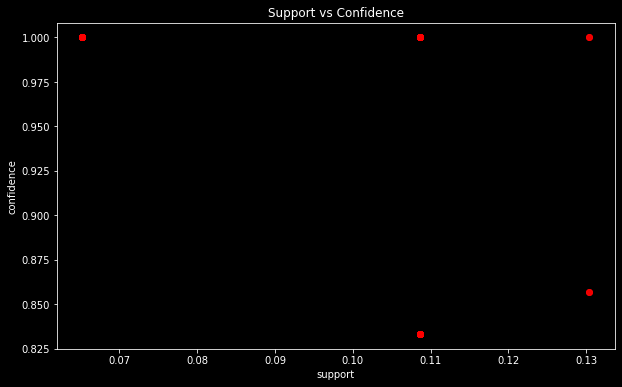

In [26]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.6, color = 'red')
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

Support vs Lift

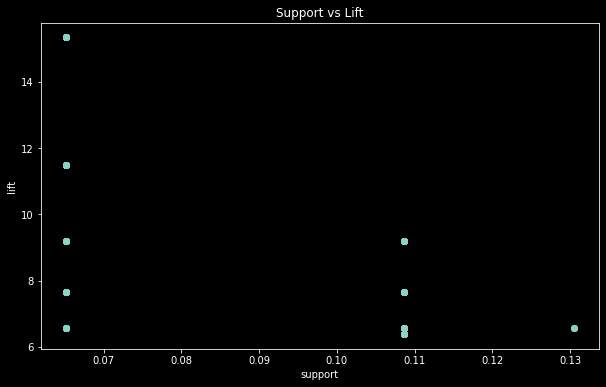

In [27]:
plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

Lift vs Cofidence

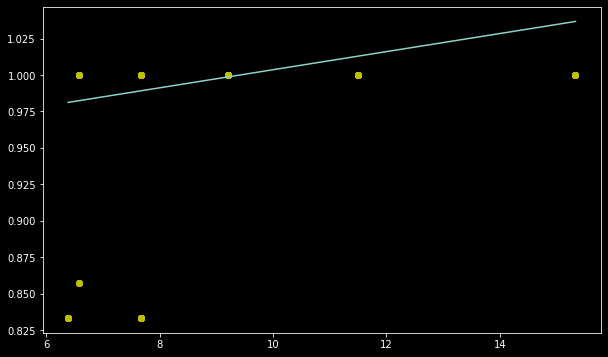

In [28]:
fit = np.polyfit(rules["lift"], rules["confidence"], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules["lift"], rules["confidence"], "yo", rules["lift"], 
fit_fn(rules["lift"]))

## Contoh 2, Dataset Groceries Store

Data yang digunakan merupakan data transaksi toko makanan

Data Source : https://www.kaggle.com/irfanasrullah/groceries

### 1. Meload dan Mengeksplor data

In [29]:
file_2 = 'drive/My Drive/Dataset/groceries_store.csv'
df_2 = pd.read_csv(file_2)
df_2.head()

,Item(s),Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,Item 16,Item 17,Item 18,Item 19,Item 20,Item 21,Item 22,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32
0,4,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9835 entries, 0 to 9834
Data columns (total 33 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Item(s)  9835 non-null   int64 
 1   Item 1   9835 non-null   object
 2   Item 2   7676 non-null   object
 3   Item 3   6033 non-null   object
 4   Item 4   4734 non-null   object
 5   Item 5   3729 non-null   object
 6   Item 6   2874 non-null   object
 7   Item 7   2229 non-null   object
 8   Item 8   1684 non-null   object
 9   Item 9   1246 non-null   object
 10  Item 10  896 non-null    object
 11  Item 11  650 non-null    object
 12  Item 12  468 non-null    object
 13  Item 13  351 non-null    object
 14  Item 14  273 non-null    object
 15  Item 15  196 non-null    object
 16  Item 16  141 non-null    object
 17  Item 17  95 non-null     object
 18  Item 18  66 non-null     object
 19  Item 19  52 non-null     object
 20  Item 20  38 non-null     object
 21  Item 21  29 non-null     object
 22  

### 2. Mentransformasi bentuk dataframe

In [31]:
df_2.shape

(9835, 33)

Merubah bentuk dari dataframe ke list, agar bisa dibentuk ulang ke dataframe yang baru.
Disini saya membatasi jumlah baris dari 9835 ke 1000 karena memori saya tidak sanggup mengolahnya

In [32]:
records = []
for i in range (0, 1000):
  records.append([str(df_2.values[i,j]) for j in range(1,33) if str(df_2.values[i,j])!='nan'])

In [33]:
records[0]

['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']

Transformasi data frame dengan TransactionEncoder()

In [34]:
TE = TransactionEncoder()
arr = TE.fit(records).transform(records)
df_2_transf = pd.DataFrame(arr, columns = TE.columns_)
df_2_transf

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cookware,cream cheese,curd,curd cheese,decalcifier,...,root vegetables,rubbing alcohol,rum,salad dressing,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,spices,spread cheese,sugar,sweet spreads,syrup,tea,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [35]:
df_2_transf.isna().sum().sum()

0

### 3. Memfilter transaksi dan hanya mengambil yang melakukan pembelian lebih dari 1 item

In [36]:
df_2_filter = df_2_transf[(df_2_transf > 0).sum(axis=1) >= 2]
df_2_filter.shape

(784, 156)

Visualisasi tipe makanan yang paling banyak di jual

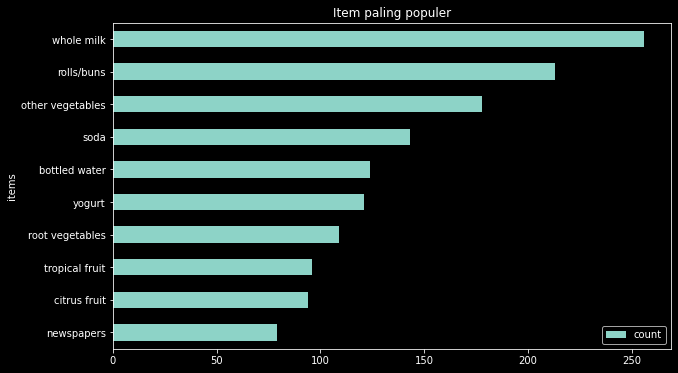

In [37]:
count = df_2_filter.loc[:,:].sum()
pop_item = count.sort_values(0, ascending = False).head(10)
pop_item = pop_item.to_frame()
pop_item = pop_item.reset_index()
pop_item = pop_item.rename(columns = {"index": "items", 0: "count"})

plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('dark_background')
ax = pop_item.plot.barh(x = 'items', y = 'count')
plt.title('Item paling populer')
plt.gca().invert_yaxis()

### 4. Menerapkan algoritma apriori

Selanjutnya adalah membuat variabel dimana terdiri dari beberapa barang yang sering terbeli dari seluruh transaksi menggunakan apriori, dengan min_support 0.05.

secara default, apriori mengembalikan index colom item, olehnya ditambahkan parameter use_columnames=True untuk merubah nilai integer ke nama item masing-masing:

In [38]:
# hasil apriori diurutkan berdasarkan nilai support secara menurun
# reset index dan menghapus index yang lama
frq_is = apriori(df_2_filter, 
                       min_support=0.05,
                       use_colnames=True).sort_values(
                           'support',
                           ascending=False
                       ).reset_index(drop=True)
frq_is['length'] = frq_is["itemsets"].apply(lambda x: len (x))
frq_is.head()

,support,itemsets,length
0,0.326531,(whole milk),1
1,0.271684,(rolls/buns),1
2,0.227041,(other vegetables),1
3,0.182398,(soda),1
4,0.158163,(bottled water),1


In [39]:
# Melihat panjang maximal itemset yang terbentuk
frq_is["length"].max()

2

### 5. Mencari asosiasi diantara *Frequent itemsets*

In [40]:
rul = association_rules(frq_is, 
                  metric='lift', 
                  min_threshold=1).sort_values(["confidence", "lift"],ascending=[False,False]).reset_index(drop=True)
rul.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(yogurt),(whole milk),0.154337,0.326531,0.071429,0.462810,1.417355,0.021033,1.253689
1,(root vegetables),(whole milk),0.139031,0.326531,0.062500,0.449541,1.376720,0.017102,1.223469
2,(other vegetables),(whole milk),0.227041,0.326531,0.091837,0.404494,1.238764,0.017701,1.130920
3,(root vegetables),(other vegetables),0.139031,0.227041,0.054847,0.394495,1.737553,0.023281,1.276554
4,(soda),(rolls/buns),0.182398,0.271684,0.062500,0.342657,1.261236,0.012945,1.107971
